# Does You Look Like

In [58]:
os.path.abspath(os.path.join('.', 'model'))

'C:\\Users\\Стас\\!Analitic\\Start in ML\\DoesYouLookLike_JN\\model'

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from bing_image_downloader.downloader import download
import face_recognition
from PIL import Image
import pickle
import json
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



from sklearn.metrics import f1_score
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

''' Главное чтобы все параметры из конфига подтянуть'''

' Главное чтобы все параметры из конфига подтянуть'

In [2]:
# download_pics
target_actors = ['Angelina Jolie', 'Helena Bonham Carter', 'Jennifer Aniston', 'Julia Roberts', 'Kate Beckinsale',
                 'Keira Knightley', 'Lindsey Stirling', 'Marilyn Monroe', 'Monica Bellucci', 'Lucy Liu', 'Scarlett Johansson']

path_to_images_dir = os.path.abspath(os.path.join('E:', 'Python', 'BOT', 'image'))
path_model = os.path.abspath(os.path.join('E:', 'Python', 'BOT', 'model'))
size_image_new = 256
size_image_test = 512
limit_load_image = 15
random_state = 13
test_size = 0.25
coef_C = 1.0
n_splits = 3

1 - download_images (+ rename_dir + count_files_in_dir)

2 - reformat_photo

3 - GetEmbedding(get_embedding)

4 - Загрузка данных + обучение модели + тест модели + сохранение модели в pickle

(1-4) выполняются единоразово - для создания обученной модели
 
.

5 - Загрузка фото с поиском лица + загрузка модели + предсказание

6 - Вывод инфы в бота

In [3]:
def download_images(path_download: str, actors: list, limit_load: int=15) -> None:
    '''
    Загрузка изображений указанных актёров/актрис
    
    :param path_download: путь для сохранения изображений на сервере
    :param actors: список актёров/актрис
    :param limit_load: количество изображений для загрузки
    
    :return: None
    '''
    
    # проверка наличия каталогов с изображениями
    # удаление в случае нахождения
    try:
        shutil.rmtree(path_download)
        print('Дерево каталогов удалено')
    except OSError as e:
        print('Error: %s : %s' % (path_download, e.strerror))

    # загрузка изображений из Bing
    for name_actor in tqdm(actors):
        find_string = f'face {name_actor}'
        download(find_string, limit=limit_load,  output_dir=path_download,
                 adult_filter_off=True, force_replace=False, timeout=60, verbose=False)
        
        # переименование каталогов с загруженными изображениями
        rename_dir(path_download, find_string, name_actor)
        
        # подсчёт количества загруженных изображений по каждому запросу
        # с удалением при количестве < 2
        if count_files_in_dir(path_download, name_actor):
            actors.remove(name_actor)

        
def rename_dir(path_dir: str, name_old: str, name_new: str) -> None:
    '''
    Переименование каталога
    
    :param path_dir: путь хранения каталогов
    :param name_old: старое имя каталога
    :param name_new: новое имя каталога
    
    :return: None        
    '''
    
    path_old = os.path.join(path_dir, name_old)
    path_new = os.path.join(path_dir, name_new)
    os.rename(path_old, path_new) 

    
def count_files_in_dir(path_dir: str, name_dir: str) -> bool:
    '''
    Оценка количества файлов в каталогах
    
    :param path_dir: путь хранения каталогов
    :param name_dir: наименование проверяемого каталога
    
    :return: True (if < 2) / False
    :rtype: bool
    '''
    
    path_listdir = os.path.join(path_dir, name_dir)
    files = len(os.listdir(path_listdir))
    if files < 2:
        return True
    return False

In [4]:
def reformat_photo(path_load: str, actors: list, size_new: int) -> None:
    '''
    Изменение размера всех изображений
    :param path_load: путь до каталогов с изображениями
    :param actors: список актёров/актрис
    :param size_new: необходимый размер изображения по одной из сторон
    
    :return: None
    '''
    
    for name in actors:
        path_to_images = os.path.join(path_load, name)
        images = os.listdir(path_to_images)
        for img in images:
            path_image = os.path.join(path_to_images, img)
            # изменение формата изображения и сохранения под тем же именем
            with Image.open(path_image) as photo:
                photo_resized = resize_photo(photo, size_new)
                photo_resized_conv = photo_resized.convert('RGB')
                photo_resized_conv.save(path_image)
                
def resize_photo(image: Image, size_new: int) -> Image:
    '''
    Изменение размера изображения
    :param image: исходное изображение
    :param size_new: необходимый размер изображения по одной из сторон
    
    :return: финальное изображение
    :rtype: Image
    '''
    
    # получение размера исходного изображения
    size = image.size
    
    # рассчёт коэффициента по одной из сторон
    coef = size_new / size[0]
    first_side = int(size[0] * coef)
    second_side = int(size[1] * coef)
    
    # изменение размера изображения
    resized_image = image.resize((first_side, second_side))
    resized_image = resized_image.convert('RGB')
    return resized_image

In [5]:
class GetEmbedding:
    '''
    Поиск лиц на фотографиях, и сохранение полученных эмбедингов в pickle
    
    
    Args:
        actors (list): список актёров/актрис 
        path_load (str): путь до каталогов с изображениями
        path_save (str): путь сохранения эмбеддингов и таргетов
        
    '''
    
    def __init__(self, actors: list, path_load: str, path_save: str):
        self.actors = actors
        self.path_load = path_load
        self.path_save = path_save
        
    def get_save_embedding(self) -> None:
        ''' Получение эмбеддингов, таргетов, имён с индексами, и сохранение в файлы '''
        
        embeddings, targets, name_labels = self.__create_embedding()
        
        path_emb = os.path.join(self.path_save, 'embeddings.pkl')
        with open(path_emb, 'wb') as f:
            pickle.dump(embeddings, f)
        
        path_tar = os.path.join(self.path_save, 'targets.pkl')
        with open(path_tar, 'wb') as f:
            pickle.dump(targets, f)
            
        path_act = os.path.join(self.path_save, 'name_labels.json')
        json_act = json.dumps(name_labels, indent=4)
        with open(path_act, 'w') as f:
            f.write(json_act)
        
    def __create_embedding(self) -> tuple[np.array, list, dict]:
        '''
        Поиск лиц,
        и формирование эмбеддингов, таргетов и словаря имена:таргеты

        :return: эмбеддинги, таргеты, словарь имена:таргеты
        :rtype: tuple[np.array, list, dict]
        '''
        
        embeddings = np.empty(128)
        targets = []
        name_labels = self.__create_labels()
        for name in self.actors:
            path_to_images = os.path.join(self.path_load, name)
            images_for_name = os.listdir(path_to_images)
            for img in images_for_name:
                try:
                    path_image = os.path.join(path_to_images, img)
                    face = face_recognition.load_image_file(path_image)
                    
                    face_boxes = face_recognition.face_locations(face)
                    # если найдено больше 1 лица на изображении - оно исключается
                    if len(face_boxes) != 1:
                        continue
                        
                    try:
                        face_encod = face_recognition.face_encodings(face)[0]
                        embeddings = np.vstack((embeddings, face_encod))
                        # добавление таргета по имени
                        targets.append(name_labels[name])
                    except Exception as ex:
                        print(f'Error: {ex}')
                    
                except Exception as ex:
                    print(f'Error: {ex}')
                    
        return embeddings[1:], targets, name_labels
                    
    def __create_labels(self) -> dict:
        ''' Создание словаря имена:таргеты '''
        
        name_labels = dict()
        for label, name in enumerate(self.actors):
            name_labels[name] = label
        return name_labels

In [6]:
# Вторая версия (с Кросс-валидацией) даёт результат хуже
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegressionCV

In [7]:
class ModelImgLR:
    '''
    Модель логистической регрессии
    
    
    Args:
        path_load (str): путь до каталога с эмбеддингами и таргетами
        random_state (int): параметр random_state
        test_size (float): параметр test_size для train_test_split
        coef_C (float): параметр C для логистической регрессии
    '''
    
    def __init__(self, path_load:str, random_state: int=0, test_size: float=0.3, n_splits: int=5, coef_C: float = 1.0):
        self.path_load = path_load
        self.test_size = test_size
        self.random_state = random_state
        self.coef_C = coef_C
        #self.skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        
        # загрузка эмбеддингов и таргетов
        self.embeddings, self.targets = self.__load_data()

    def fit_model(self) -> LogisticRegression:
        ''' 
        Обучение модели, 
        сохранение в pickle, в каталог с эмбеддингами и таргетами

        :return: модель машинного обучения, тестовые данные X_test и y_test
        :rtype: LogisticRegression, np.array, np.array

        '''
        
        min_num_target, name_min_target = self.__check_min_target()
        if min_num_target > 1:
            X_train, X_test, y_train, y_test = train_test_split(self.embeddings, self.targets, 
                                                                test_size=self.test_size, 
                                                                random_state=self.random_state,
                                                                stratify=self.targets)
            
            #log_values = np.logspace(-1, 10, 500)
            #model_LR = LogisticRegressionCV(cv=self.skf, Cs=log_values, random_state=self.random_state, solver='newton-cg')
            model_LR = LogisticRegression(random_state=self.random_state, C = self.coef_C)
            model_LR.fit(X_train, y_train)
            
            self.__save_model(model_LR)
            
            return model_LR, X_test, y_test
        else:
            #logging.info(f'Problem with data. Target: {name_min_target}')
            print(f'Problem with data. Target: {name_min_target}')
    
    def __load_data(self) -> tuple[np.array, list]:
        ''' Загрузка данных для обучения '''
        
        try:
            path_embeddings = os.path.join(self.path_load, 'embeddings.pkl')
            with open(path_embeddings, 'rb') as file:
                load_embeddings = pickle.load(file)

            path_targets = os.path.join(self.path_load, 'targets.pkl')
            with open(path_targets, 'rb') as file:
                load_targets = pickle.load(file)
        except Exception as ex:
                        print(f'Error: {ex}')
        else:
            return load_embeddings, load_targets
        
    def __check_min_target(self) -> tuple[int, str]:
        ''' Подсчёт количества каждой из меток в списке, с нахождением минимального '''

        targets_counter = Counter(self.targets)
        min_num_target = np.inf
        name_min_target = ''
        for target in targets_counter.keys():
            if targets_counter[target] < min_num_target:
                min_num_target = targets_counter[target]
                name_min_target = target

        return min_num_target, str(name_min_target)
    
    def __save_model(self, model_LR: LogisticRegression) -> None:
        ''' Сохранение модели логистической регрессии в файл '''
        
        path_save = os.path.join(self.path_load, 'model_LR.pkl')
        with open(path_save, 'wb') as f:
            pickle.dump(model_LR, f)
        

    # ну и запуск всего добра
    #__name__ == __main__:
''' запуск всего скрипта на обучение, файлы до этого не запускаются сами '''
''' С проверкой на необходимость закачки и предобработки данных! '''

' С проверкой на необходимость закачки и предобработки данных! '

In [8]:
# download_images(path_to_images_dir, target_actors, limit_load_image)

In [9]:
#reformat_photo(path_to_images_dir, target_actors, size_image_new)
#actors_embedding = GetEmbedding(target_actors, path_to_images_dir, path_model)
#actors_embedding.get_save_embedding()

In [10]:
#MyModel = ModelImgLR(path_model, random_state, test_size, n_splits)
MyModel = ModelImgLR(path_model, random_state, test_size, coef_C)
model_LR, X_test, y_test = MyModel.fit_model()
f1_model_score = f1_score(y_test, model_LR.predict(X_test), average='micro')
print(f'F1 score: {f1_model_score}')

F1 score: 1.0


In [11]:
class PredictModelImgLR:
    '''
    Предсказание на модели логистической регрессии по тестовому изображению
    
    
    Args:
        path_load (str): путь до каталога с тестовым изображением
        size_new (int): необходимый размер изображения по одной из сторон
    '''
    
    def __init__(self, path_load:str, size_new:int):
        self.path_load = path_load
        self.size_new = size_new
        
        # загрузка модели, словаря имён:таргетов
        self.model, self.name_labels = self.__load_data()

    def predict_model(self) -> None:
        ''' Предсказание на модели логистической регрессии '''
        
        test_photo_resized_conv = self.__load_image()
        
        test_face_boxes = face_recognition.face_locations(test_photo_resized_conv)
        # если найдено больше 1 лица на изображении - оно исключается
        if len(test_face_boxes) == 1:
            test_face_encod = face_recognition.face_encodings(test_photo_resized_conv)[0]
            test_predict = self.model.predict([test_face_encod])
            test_predict_name = list(self.name_labels.keys())[list(self.name_labels.values()).index(test_predict)]
            print('predict: %d' % test_predict)
            print('predict name: %s' % test_predict_name)
            
            
            test_predict_proba = self.model.predict_proba([test_face_encod])[0][test_predict][0]
            print(test_predict_proba)
            
    
    def __load_data(self) -> tuple[np.array, dict]:
        ''' Загрузка данных для обучения '''
        
        try:
            path_model = os.path.join(self.path_load, 'model_LR.pkl')
            with open(path_model, 'rb') as file:
                load_model = pickle.load(file)

            path_act = os.path.join(self.path_load, 'name_labels.json')
            with open(path_act, 'r') as file:
                load_name_labels = json.load(file)
        except Exception as ex:
                        print(f'Error: {ex}')
        else:
            return load_model, load_name_labels
        
    def __load_image(self) -> np.array(Image):
        ''' Загрузка изображения, с изменением размера '''
        
        path_test_image = os.path.join(self.path_load, 'test_image1.jpg')
        # изменение формата тестового изображения
        with Image.open(path_test_image) as photo:
            test_photo_resized = resize_photo(photo, self.size_new)
            test_photo_resized_conv = np.array(test_photo_resized.convert('RGB'))
        
        return test_photo_resized_conv

In [12]:
predict_model_img_lr = PredictModelImgLR(path_model, size_image_test)
predict_model_img_lr.predict_model()

predict: 3
predict name: Julia Roberts
0.41638131687894564


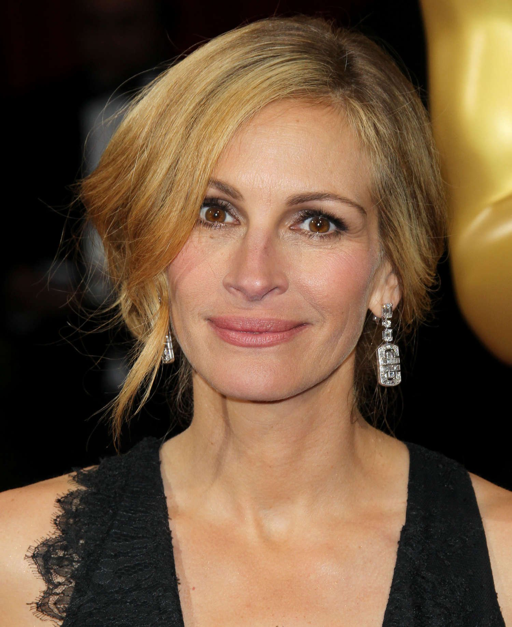

In [17]:
# test_image1.jpg:
with Image.open(path_test_image) as photo:
    test_photo_resized = resize_photo(photo, size_image_test)
    test_photo_resized_conv = test_photo_resized.convert('RGB')
test_photo_resized_conv